## Real Estate Price Prediction in Belgium

In [1]:
# import created modules
from source.data_cleaning import DataCleaning as dtcln
from source.data_cleaning import describe_with_tukey_fences
import source.modeling as modeling
import source.evaluation as evaluation

# import standard libraries
import os
import numpy as np
import pandas as pd
import scipy.stats as stats

#import scikit modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt


from tabulate import tabulate
#below two packages are for feature selection
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel


REAL_ESTATE_CSV_FILEPATH = os.path.join(os.getcwd(), 'data', 'clean_dataset.csv')
CLEANED_CSV_FILEPATH = os.path.join(os.getcwd(), 'assets', 'outputs', 'df_after_cleaning.csv')


#['source','land_surface', 'facades_number', 'swimming_pool_has','postcode_median_price',
#              'property_subtype_median_facades_number', 'building_state_agg_median_price']
NUM_CV_FOLDS = 3
DEGREE_MAX = 3

## Data preprocessing: cleaning and conversion from text to numerical


In [2]:
cleaner = dtcln(csv_filepath=REAL_ESTATE_CSV_FILEPATH)
df, df_outliers = cleaner.get_cleaned_dataframe(cleaned_csv_path=CLEANED_CSV_FILEPATH)
#excluding text columns as requested (boolean kept)
df = df.select_dtypes(exclude=['object'])

Initial dataset, shape: (10607, 19)
Aggregated parameters replacing categorical ones, shape: (10607, 19)
0 Dropped duplicates, shape: (10607, 19)
1313 Dropped outliers, shape: (9294, 19)


In [3]:
#show results of outliers detection and removal
df_outliers

,column,method,type,count,%,first_outlier,index
0,price,fence_tukey_max,max,994,9.37,988000.0,"[8, 20, 35, 36, 45, 56, 58, 61, 62, 71, 83, 89..."
1,rooms_number,fence_tukey_max,max,246,2.32,8.0,"[16, 18, 19, 35, 36, 45, 56, 71, 81, 83, 86, 9..."
2,area,fence_tukey_max,max,686,6.47,410.0,"[8, 20, 23, 35, 36, 45, 56, 62, 71, 80, 83, 92..."


In [4]:
#show no null values and no text types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9294 entries, 0 to 10606
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   source                9294 non-null   int64  
 1   postcode              9294 non-null   int64  
 2   house_is              9294 non-null   bool   
 3   price                 9294 non-null   float64
 4   rooms_number          9294 non-null   float64
 5   area                  9294 non-null   float64
 6   equipped_kitchen_has  9294 non-null   bool   
 7   furnished             9294 non-null   bool   
 8   open_fire             9294 non-null   bool   
 9   terrace               9294 non-null   bool   
 10  terrace_area          9294 non-null   float64
 11  garden                9294 non-null   bool   
 12  garden_area           9294 non-null   float64
 13  land_surface          9294 non-null   float64
 14  swimming_pool_has     9294 non-null   bool   
 15  facades_number      

In [5]:
#show statistical information to consider further processing
describe_with_tukey_fences(df)

,source,postcode,price,rooms_number,area,terrace_area,garden_area,land_surface,facades_number
count,9294.000000,9294.000000,9294.000000,9294.000000,9294.000000,9294.000000,9294.000000,9.294000e+03,9294.000000
mean,5.987734,5005.432214,346492.263611,2.749516,147.099527,10.918765,151.528083,5.757739e+02,2.251345
std,0.156154,3195.155553,187901.749352,1.267379,75.596796,22.721260,1169.734110,1.456899e+04,1.044107
min,4.000000,1000.000000,25000.000000,0.000000,5.000000,0.000000,0.000000,0.000000e+00,0.000000
5%,6.000000,1040.000000,125000.000000,1.000000,55.000000,0.000000,0.000000,0.000000e+00,0.000000
6%,6.000000,1050.000000,130000.000000,1.000000,60.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,6.000000,1500.000000,215000.000000,2.000000,91.000000,0.000000,0.000000,0.000000e+00,2.000000
50%,6.000000,4540.000000,297500.000000,3.000000,130.000000,0.000000,0.000000,0.000000e+00,2.000000
75%,6.000000,8400.000000,430000.000000,3.000000,188.000000,15.000000,0.000000,3.157500e+02,3.000000
94%,6.000000,9300.000000,720000.000000,5.000000,291.000000,41.000000,544.200000,1.438840e+03,4.000000


## Features selection

In [6]:
#Drop features which are not relevent
#FM facades improve you could have a look at it
df = df.drop(['source','land_surface', 'swimming_pool_has'],axis=1)
#calculating price per metre square to detect outliers
df['price_per_sqmtr'] = df['price'] / df['area']

In [7]:
#postcode_stats contains the no. of properties in each postcode
postcode_stats = df['postcode'].value_counts(ascending=False)

Any location having less than 10 data points should be tagged as "9999" location.
This way number of categories can be reduced by huge amount.
Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [8]:
postcode_value_less_than_10 = postcode_stats[postcode_stats<=10]
postcode_value_less_than_10
df['postcode'] = df['postcode'].apply(lambda x: '9999' if x in postcode_value_less_than_10 else x)

In [9]:
#FM I would not remove outliers by SD since distribution does not seem normal to me
''' Outlier Removal Using Standard Deviation and Mean '''
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key,subdf in df.groupby('postcode'):
        m =np.mean(subdf.price_per_sqmtr)
        sd = np.std(subdf.price_per_sqmtr)
        reduced_df = subdf[(subdf.price_per_sqmtr > (m - (2 * sd))) & (subdf.price_per_sqmtr <= (m +(2 * sd))) ]
        df_out = pd.concat([df_out,reduced_df],ignore_index= True)
    return df_out
#Applying the function on our dataframe
df = remove_pps_outliers(df)
#Now, we can drop price per metre square column as our outlier detection is done '''
df = df.drop(['price_per_sqmtr'],axis='columns')

In [10]:
''' To check correlation of features using chisquare method
It gives us the list of featues which are relevant and which are not relevant for the model '''
class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None

        self.dfObserved = None
        self.dfExpected = None

    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        #print(result)

    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)

        self.dfObserved = pd.crosstab(Y,X)
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof

        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)

        self._print_chisquare_result(colX,alpha)

#Initialize ChiSquare Class
cT = ChiSquare(df)

#Feature Selection
testColumns = ['postcode', 'house_is', 'rooms_number', #'property_subtype'
       'area', 'equipped_kitchen_has', 'furnished', 'open_fire', 'terrace',
       'garden'] #, 'building_state_agg'] #'region',
for var in testColumns:
    cT.TestIndependence(colX=var,colY="price" )

#Drop the features which are irrelevant as per chi-square '''
df = df.drop(['furnished','garden'],axis = 1) #'property_subtype'

In [11]:
#Use One Hot Encoding For postcodes
dummies = pd.get_dummies(df,prefix= '',prefix_sep = '')
#df = dummies.drop(['9999','to_renovate','B',],axis='columns') #FM add postcode if needed

In [12]:
X = df.drop(['price'],axis='columns')
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

## Machine Learning Model

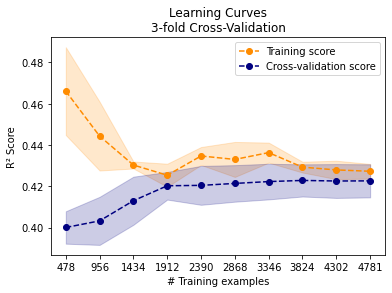

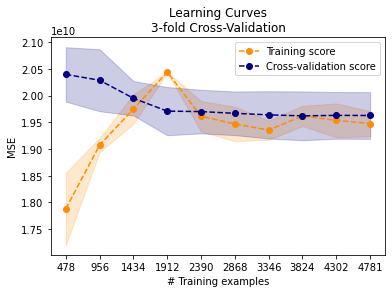

In [13]:
#Returns a linear regression model fitted with Ordinary Least Squares method
lin_reg = modeling.OLS_linear_regression(X_train, y_train)
#Plots learning curves (R² Score) based on training data and k-folds cross-validation
modeling.plot_OLS_lin_reg_r2_curves(X_train, y_train, num_cv_folds=NUM_CV_FOLDS)
#Plots learning curves (Mean Squared Error) based on training data and k-folds cross-validation
modeling.plot_OLS_lin_reg_MSE_curves(X_train, y_train, num_cv_folds=NUM_CV_FOLDS)

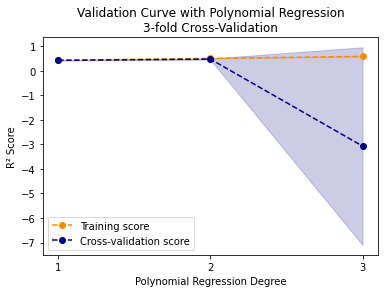

In [14]:
modeling.plot_poly_reg_validation_curves(X_train, y_train, num_cv_folds=NUM_CV_FOLDS, degree_max=DEGREE_MAX)

## Model evaluation

### Alternative path for cleaning
To be discussed together if:
1. Going for logaritmic of price. In which case it will be done at data cleaning stage

In [15]:
#FM we have to decide if we gor or not for log representation
#df['price']=np.log(df['price'])

In [16]:
#TBC
df.fillna(df.mean(), inplace=True)

### Alternative path for features
To be discussed together

In [17]:
X=df.drop('price',axis=1)
y=df['price']

In [18]:
feature_select_model=SelectFromModel(Lasso(alpha=0.005,random_state=0))
feature_select_model.fit(X,y)

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0))

In [19]:
#gives information to select the features True-select False-remove
feature_select_model.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [20]:
selected_features=X.columns[(feature_select_model.get_support())]

In [21]:
X=X[selected_features]

In [22]:
X

,postcode,house_is,rooms_number,area,equipped_kitchen_has,open_fire,terrace,terrace_area,garden_area,facades_number
0,1000,True,4.0,272.0,True,False,True,32.0,16.0,0.0
1,1000,True,4.0,180.0,True,False,True,3.0,0.0,0.0
2,1000,True,6.0,370.0,False,False,False,0.0,0.0,0.0
3,1000,True,5.0,270.0,True,False,False,0.0,0.0,0.0
4,1000,True,4.0,330.0,True,False,False,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...
8960,9999,True,3.0,360.0,True,False,True,40.0,600.0,4.0
8961,9999,True,2.0,85.0,True,False,False,0.0,0.0,3.0
8962,9999,True,3.0,153.0,True,False,True,32.0,500.0,3.0
8963,9999,False,3.0,192.0,True,False,True,48.0,0.0,2.0


#### Correlation

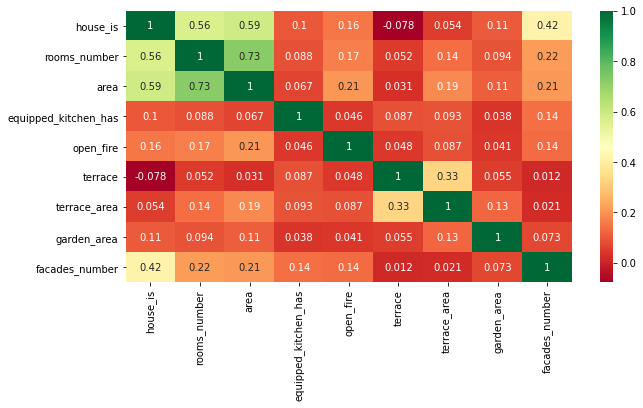

In [23]:
plt.figure(figsize=(10,5))
sns.heatmap(X.corr(),annot=True,cmap='RdYlGn')

In [24]:
#data is splitted into traning and testing set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

### Alternative path for modelling

In [25]:
# create linear regression object and fit data
lreg=LinearRegression()
lreg.fit(X_train,y_train)

LinearRegression()

In [26]:
#from source.data_cleaning import get_columns_with_nan
#get_columns_with_nan(X_train)
#y_train.isna().sum()

In [27]:
#find predicted data
ytest_prediction=lreg.predict(X_test)
ytrain_prediction=lreg.predict(X_train)
print(ytest_prediction,ytrain_prediction)

[366798.81828631 491937.51563381 652516.93261367 ... 299297.24620779
 221782.87991364 425784.78490285] [211728.73713873 173640.39769522 529531.81645902 ... 398148.8699782
 205615.20311014 338550.18473863]


In [28]:
#compute accuracy and mean error
print('Mean Square error: ', mean_squared_error(y_test,ytest_prediction)) #Manasa prediction missed ?
print('Accuracy: ', r2_score(y_test,ytest_prediction))

Mean Square error:  19206746555.744812
Accuracy:  0.4373017822533436


In [29]:
def predict_price(model, prop_type, postcode, area, rooms, garden, terrace, prop_condition):
    """
    Function predicts the price with random input data.


    :param prop_type: property type data
    :param postcode: postcode data
    :param area: area
    :param rooms: number of rooms
    :param garden: garden
    :param terrace: terrace
    :param prop_condition: proeprty condition
    :return: price value
    """
    loc_index = np.where(X.columns == postcode)[0]
    prop_condition_index = np.where(X.columns == prop_condition)[0]
    x = np.zeros(len(X.columns))
    x[0] = prop_type
    x[1] = rooms
    x[2] = area
    x[3] = terrace
    x[4] = garden

    if loc_index >= 0:
        x[loc_index] = 1

    if prop_condition_index >= 0:
        x[prop_condition_index] = 1
    
    return model.predict([x])[0]

Evaluation Metrics
╒════════╤════════╤═════════════╤════════╤═════════════════╤════════════════╕
│        │    MAE │         MSE │   RMSE │   Train_RSquare │   Test_RSquare │
╞════════╪════════╪═════════════╪════════╪═════════════════╪════════════════╡
│ Values │ 102968 │ 1.91598e+10 │ 138419 │        0.431827 │       0.438678 │
╘════════╧════════╧═════════════╧════════╧═════════════════╧════════════════╛


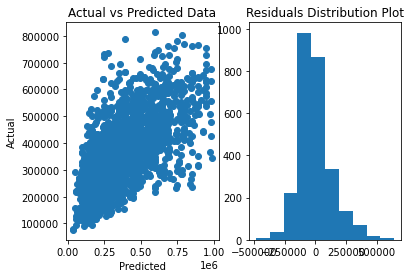

In [30]:
#lin_reg contains our previously created model
model_evaluation_obj = evaluation.Model_Evaluation(lin_reg)
ytrain_predictions, ytest_predictions = model_evaluation_obj.get_predictions(X_train, X_test)
model_evaluation_obj.predict_model(X_train, y_train, X_test, y_test)

In [31]:
predicted_price = predict_price(lin_reg, 1, 8300, 100 , 3, 1, 0,'good')
print(predicted_price)

1583455.1855052523


<ipython-input-29-017fbeed36ff>:24: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if loc_index >= 0:
<ipython-input-29-017fbeed36ff>:27: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if prop_condition_index >= 0:
